In [ ]:
! pip install qucumber

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from qucumber.nn_states import DensityMatrix

from qucumber.callbacks import MetricEvaluator
import qucumber.utils.unitaries as unitaries

import qucumber.utils.training_statistics as ts
import qucumber.utils.data as data
import qucumber

In [ ]:
train_path = "N2_W_state_100_samples_data.txt"
train_bases_path = "N2_W_state_100_samples_bases.txt"
matrix_path_real = "N2_W_state_target_real.txt"
matrix_path_imag = "N2_W_state_target_imag.txt"
bases_path = "N2_IC_bases.txt"


train_samples, true_matrix, train_bases, bases = data.load_data_DM(
    train_path, matrix_path_real, matrix_path_imag, train_bases_path, bases_path
)

In [ ]:
unitary_dict = unitaries.create_dict()
# unitary_dict = unitaries.create_dict(unitary_name=torch.tensor([[real part],
#                                                                 [imaginary part]],
#                                                                 dtype=torch.double)

In [ ]:
nv = train_samples.shape[-1]
nh = na = nv

nn_state = DensityMatrix(
    num_visible=nv, num_hidden=nh, num_aux=na, unitary_dict=unitary_dict, gpu=False
)

In [ ]:
epochs = 500
pbs = 100  # pos_batch_size
nbs = pbs  # neg_batch_size
lr = 10
k = 10
lr_drop_epoch = 125
lr_drop_factor = 0.5

In [ ]:
def partition(nn_state, space, **kwargs):
    return nn_state.rbm_am.partition(space)

In [ ]:
period = 25
space = nn_state.generate_hilbert_space()

callbacks = [
    MetricEvaluator(
        period,
        {
            "Fidelity": ts.fidelity,
            "KL": ts.KL,
            # "Partition Function": partition,
        },
        target=true_matrix,
        bases=bases,
        verbose=True,
        space=space,
    )
]

In [ ]:
nn_state.fit(
    data=train_samples,
    input_bases=train_bases,
    epochs=epochs,
    pos_batch_size=pbs,
    neg_batch_size=nbs,
    lr=lr,
    k=k,
    bases=bases,
    callbacks=callbacks,
    time=True,
    optimizer=torch.optim.Adadelta,
    scheduler=torch.optim.lr_scheduler.StepLR,
    scheduler_args={"step_size": lr_drop_epoch, "gamma": lr_drop_factor},
)

Epoch: 25	Fidelity = 0.812096	KL = 0.058345
Epoch: 50	Fidelity = 0.921134	KL = 0.025325
Epoch: 75	Fidelity = 0.953694	KL = 0.016185
Epoch: 100	Fidelity = 0.962641	KL = 0.011825
Epoch: 125	Fidelity = 0.967691	KL = 0.011329
Epoch: 150	Fidelity = 0.963026	KL = 0.016241
Epoch: 175	Fidelity = 0.966871	KL = 0.011842
Epoch: 200	Fidelity = 0.968969	KL = 0.009766
Epoch: 225	Fidelity = 0.971531	KL = 0.009492
Epoch: 250	Fidelity = 0.969102	KL = 0.011085
Epoch: 275	Fidelity = 0.972579	KL = 0.008959
Epoch: 300	Fidelity = 0.969316	KL = 0.010581
Epoch: 325	Fidelity = 0.971396	KL = 0.008694
Epoch: 350	Fidelity = 0.970907	KL = 0.009613
Epoch: 375	Fidelity = 0.966914	KL = 0.011451
Epoch: 400	Fidelity = 0.973038	KL = 0.008630
Epoch: 425	Fidelity = 0.970127	KL = 0.009940
Epoch: 450	Fidelity = 0.970290	KL = 0.009861
Epoch: 475	Fidelity = 0.972642	KL = 0.008852
Epoch: 500	Fidelity = 0.971672	KL = 0.010061
Total time elapsed during training: 169.185 s


In [ ]:
fidelities = callbacks[0]["Fidelity"]
KLs = callbacks[0]["KL"]
epoch = np.arange(period, epochs + 1, period)

Text(0.5, 0, 'Epoch')

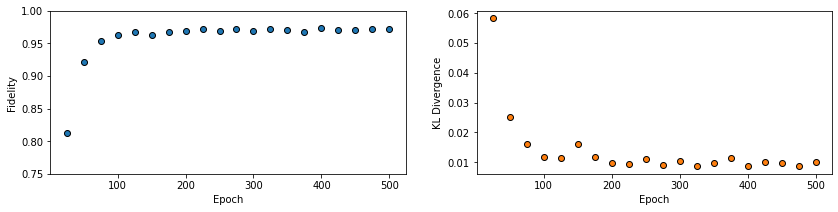

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 3))
ax = axs[0]
ax.plot(epoch, fidelities, "o", color="C0", markeredgecolor="black")
ax.set_ylabel(r"Fidelity")
ax.set_xlabel(r"Epoch")
ax.set_ylim(0.75, 1.00)

ax = axs[1]
ax.plot(epoch, KLs, "o", color="C1", markeredgecolor="black")
ax.set_ylabel(r"KL Divergence")
ax.set_xlabel(r"Epoch")

In [ ]:
nn_state.save("saved_params_W_state.pt")